In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import Accuracy, Precision, Recall

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
#we load a torch dataset, then use DataLoader for the Loop.
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:06<00:00, 4.17MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 185kB/s]
100%|██████████| 4.42M/4.42M [00:03<00:00, 1.15MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.01MB/s]


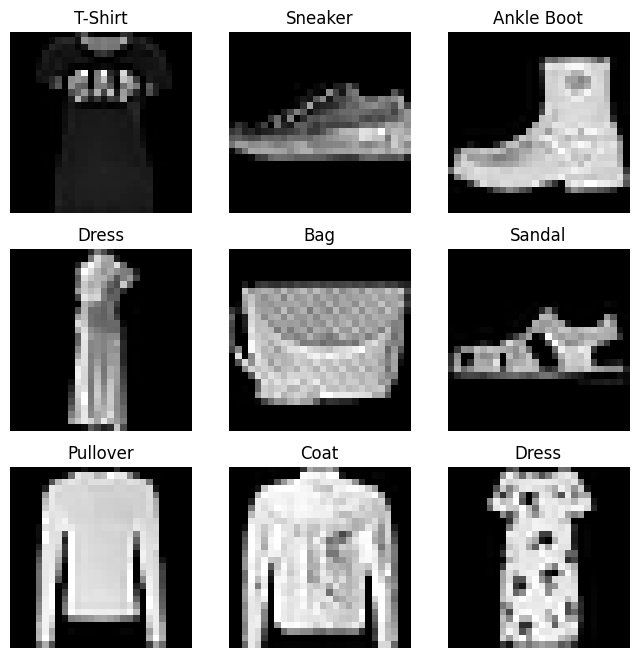

In [3]:
import matplotlib.pyplot as plt
labels_map = {
        0: "T-Shirt",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    }

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")



In [4]:
classes=train_data.classes
num_classes=len(classes)
print(classes)
print(num_classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
10


In [5]:
inp_channels=1
out_channels=16
image_size=train_data[0][0].shape[1]
print(image_size)

class Fashion(nn.Module):
    def __init__(self,num_classes):
        super(Fashion, self).__init__()
        self.conv1=nn.Conv2d(inp_channels,out_channels,kernel_size=3,stride=1,padding=1)
        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(kernel_size=2,stride=2)
        self.flatten=nn.Flatten()
        self.fc=nn.Linear(out_channels*(image_size//2)**2,num_classes)

    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(x)
        x=self.maxpool(x)
        x=self.flatten(x)
        x=self.fc(x)
        return x

28


In [6]:
dataloader_train=DataLoader(train_data, batch_size=10,shuffle=True)

def Train(optimizer, net,epochs):
    criterion=nn.CrossEntropyLoss()
    for epoch in range(epochs):
        run_loss=0
        processed=0
        for feature,label in dataloader_train:
            optimizer.zero_grad()
            output=net(feature)
            loss=criterion(output,label)
            loss.backward()
            optimizer.step()
            run_loss+=loss.item()
            processed+=len(label)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {run_loss/processed:.4f}')
    train_loss=run_loss/len(dataloader_train)
    return train_loss


In [7]:
net=Fashion(num_classes)
optimizer=optim.Adam(net.parameters(),lr=0.001)
out=Train(optimizer,net,epochs=5)
print(out)


Epoch 1/5, Loss: 0.0404
Epoch 2/5, Loss: 0.0291
Epoch 3/5, Loss: 0.0258
Epoch 4/5, Loss: 0.0237
Epoch 5/5, Loss: 0.0220
0.22016524577969296


In [8]:
dataloader_test=DataLoader(test_data, batch_size=10,shuffle=False)
accuracy=Accuracy(task='multiclass', num_classes=num_classes)
precision=Precision(task='multiclass', num_classes=num_classes, average=None)
recall=Recall(task='multiclass', num_classes=num_classes, average=None)

#evaluation loop: 
net.eval()
predictions=[]
for i,(features,labels) in enumerate(dataloader_test):
    output=net.forward(features.reshape(-1,1,image_size,image_size))
    cat=torch.argmax(output,dim=-1)
    predictions.extend(cat.tolist())
    accuracy(cat,labels)
    precision(cat,labels)
    recall(cat,labels)

accuracy=accuracy.compute().item()
precision=precision.compute().tolist()
recall=recall.compute().tolist()

print('Accuracy:',accuracy)
print('Precision (per class):',precision)
print('Recall (per class):',recall)

Accuracy: 0.9017999768257141
Precision (per class): [0.9002293348312378, 0.9908257126808167, 0.8166510462760925, 0.8728813529014587, 0.8503054976463318, 0.9780219793319702, 0.7107279896736145, 0.9613478779792786, 0.9877175092697144, 0.9670987129211426]
Recall (per class): [0.7850000262260437, 0.972000002861023, 0.8730000257492065, 0.9269999861717224, 0.8349999785423279, 0.9789999723434448, 0.7419999837875366, 0.9700000286102295, 0.9649999737739563, 0.9700000286102295]


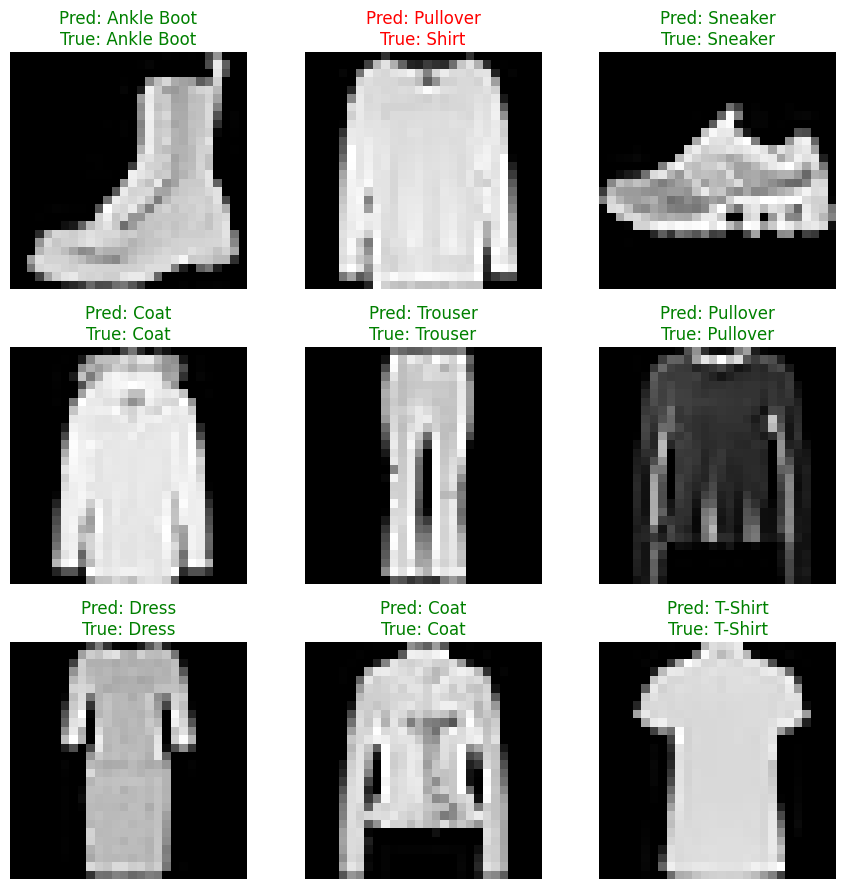

In [9]:
num_samples=9
cols=3
rows = (num_samples + cols - 1) // cols
figure = plt.figure(figsize=(cols * 3, rows * 3))

net.eval()
with torch.no_grad():
    for i in range(1, num_samples + 1):
        sample_idx = torch.randint(len(test_data), size=(1,)).item()
        img, label = test_data[sample_idx]

        output = net(img.unsqueeze(0))
        pred_label = torch.argmax(output, dim=1).item()

        figure.add_subplot(rows, cols, i)
        color = "green" if pred_label == label else "red"
        plt.title(f"Pred: {labels_map[pred_label]}\nTrue: {labels_map[label]}", color=color)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")

plt.tight_layout()
plt.show()